Giacomo Fidone

g.fidone1@studenti.unipi.it

## Imports

In [1]:
!pip install datasets
!pip install evaluate
!pip install transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 14.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datasets
import evaluate

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

from sklearn.metrics import classification_report, confusion_matrix

## Stile

In [3]:
# specifico lo stile dei grafici

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})

## Data Preparation

In [4]:
# carico il dataset
df = pd.read_csv('/content/drive/My Drive/dataset_ironita_2018.csv')

In [5]:
df.shape

(4849, 6)

In [6]:
df.head()

,twitter_id,text,irony,sarcasm,source,set
0,595524450503815168,-Prendere i libri in copisteria-Fare la spesa-...,1,0,twita-crowd,test
1,578468106504433665,...comunque con una crociera Costa se non ti a...,1,0,HSC,test
2,577791521174466560,"“@TweetComici: Ogni ragazza: \""non sono una ra...",1,1,twita-crowd,test
3,507464919303069697,“La buona scuola”? Fa gli errori di grammatica...,0,0,tw-bs,test
4,839896135619727362,“Vi hanno sfrattato? Andate al campo rom in un...,0,0,HSC,test


In [7]:
# genero la variabile multi-classe irony_sarcasm e la sostituisco a sarcasm

irony_sarcasm = []
for i, row in df.iterrows():
    if row['irony'] == 0 and row['sarcasm'] == 0:
        irony_sarcasm.append(0)
    elif row['irony'] == 1 and row['sarcasm'] == 0:
        irony_sarcasm.append(1)
    else:
        irony_sarcasm.append(2)
df['irony_sarcasm'] = irony_sarcasm
df = df.drop('sarcasm', axis=1)

In [8]:
df.shape

(4849, 6)

In [9]:
df.head()

,twitter_id,text,irony,source,set,irony_sarcasm
0,595524450503815168,-Prendere i libri in copisteria-Fare la spesa-...,1,twita-crowd,test,1
1,578468106504433665,...comunque con una crociera Costa se non ti a...,1,HSC,test,1
2,577791521174466560,"“@TweetComici: Ogni ragazza: \""non sono una ra...",1,twita-crowd,test,2
3,507464919303069697,“La buona scuola”? Fa gli errori di grammatica...,0,tw-bs,test,0
4,839896135619727362,“Vi hanno sfrattato? Andate al campo rom in un...,0,HSC,test,0


In [10]:
# separo train e test
df_train = df[df['set'] == 'training']
df_test = df[df['set'] == 'test']

In [11]:
print(df_train.shape, df_test.shape)

(3977, 6) (872, 6)


## Classificazione binaria di Irony

In [21]:
# formatto i dati per passarli a transformer.Dataset

train = df_train[['twitter_id', 'text', 'irony']]
train = train.rename(columns={'irony': 'label'})
test = df_test[['twitter_id', 'text', 'irony']]
test = test.rename(columns={'irony': 'label'})

In [22]:
print(train.shape, test.shape)

(3977, 3) (872, 3)


In [23]:
train.head()

,twitter_id,text,label
872,790984955396489217,in Europa #Renzi batte i pugni per migranti p...,0
873,511508648909344768,-Fatti i compiti per le vacanze? -No. -Cominci...,1
874,146306463130849280,: abbiamo voluto la bicicletta (il Governo Mon...,1
875,837044424626450432,: Milano: il condominio dove comandano i profu...,0
876,522755524065247232,... e alla fine nuovo (consueto) blocco del co...,1


In [24]:
test.head()

,twitter_id,text,label
0,595524450503815168,-Prendere i libri in copisteria-Fare la spesa-...,1
1,578468106504433665,...comunque con una crociera Costa se non ti a...,1
2,577791521174466560,"“@TweetComici: Ogni ragazza: \""non sono una ra...",1
3,507464919303069697,“La buona scuola”? Fa gli errori di grammatica...,0
4,839896135619727362,“Vi hanno sfrattato? Andate al campo rom in un...,0


In [25]:
# passo i pandas.DataFrame a transformer.Datasets e rimuovo la colonna corrispondente all'indice

train = datasets.Dataset.from_pandas(train)
test = datasets.Dataset.from_pandas(test)
train = train.remove_columns(["__index_level_0__"])
test = test.remove_columns(["__index_level_0__"])

In [26]:
print(train)

Dataset({
    features: ['twitter_id', 'text', 'label'],
    num_rows: 3977
})


In [27]:
print(test)

Dataset({
    features: ['twitter_id', 'text', 'label'],
    num_rows: 872
})


In [28]:
# Separo train e validation

train_dev = train.train_test_split(test_size=0.1)

train = train_dev["train"]
val = train_dev["test"]

In [29]:
print(train)

Dataset({
    features: ['twitter_id', 'text', 'label'],
    num_rows: 3579
})


In [30]:
print(val)

Dataset({
    features: ['twitter_id', 'text', 'label'],
    num_rows: 398
})


In [31]:
# carico il modello ed il tokenizzatore
num_labels = len(np.unique(train['label'])) # numero di classi
model_name = 'dbmdz/bert-base-italian-cased'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

In [32]:
# verifico la lunghezza massima dei testi per settare una max_length

text_lens = [len(text) for text in train['text']]
print(np.max(text_lens))

188


In [33]:
# tokenizzo i dati

def tokenize(batch):
    tokens = tokenizer(batch['text'], padding=True, truncation=True, max_length=188)
    tokens['label'] = batch['label']

    return tokens

train = train.map(tokenize, batched=True)
val = val.map(tokenize, batched=True)
test = test.map(tokenize, batched=True)

train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/3579 [00:00<?, ? examples/s]

Map:   0%|          | 0/398 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [34]:
train

Dataset({
    features: ['twitter_id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3579
})

In [35]:
val

Dataset({
    features: ['twitter_id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 398
})

In [36]:
test

Dataset({
    features: ['twitter_id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 872
})

In [37]:
# inizializzo i TrainingArgumets

training_args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy = "epoch",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

In [38]:
# definisco una funzione per la valutazione del modello (f1-macro)

def compute_metrics(eval_pred):
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)

  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [39]:
# inizializzo il Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [40]:
# addestro e salvo il modello

trainer.train()
trainer.save_model("/content/drive/My Drive/FINETUNED_MODEL_irony")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.570800,0.612307,0.673106
2,0.409500,0.572040,0.749738
3,0.268700,0.923463,0.746217
4,0.160900,1.234903,0.760967
5,0.076400,1.347927,0.763095


<ipython-input-45-696a0b0f1070>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "TR"}, ignore_index=True)
<ipython-input-45-696a0b0f1070>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "VL"}, ignore_index=True)
<ipython-input-45-696a0b0f1070>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "TR"}, ignore_index=True)
<ipython-input-45-696a0b0f1070>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(

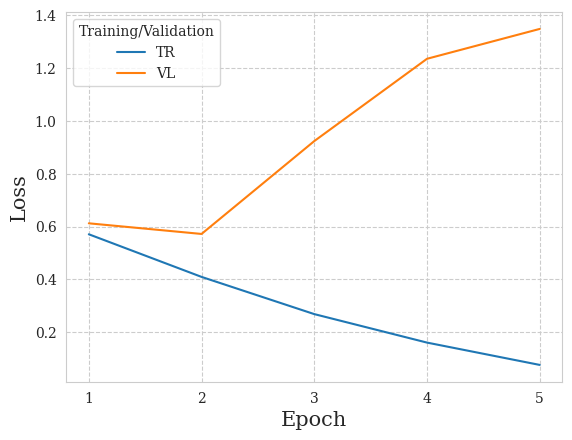

In [45]:
# visualizzo la loss su TR/VL

log_history = trainer.state.log_history
data = pd.DataFrame(columns=["Epoch", "Loss", "Training/Validation"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    data = data.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "TR"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    data = data.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "VL"}, ignore_index=True)

# Lineplot della loss
sns.lineplot(data=data, x="Epoch", y="Loss", hue="Training/Validation")
plt.xticks(range(1, 6))
plt.show()

In [46]:
# calcolo le predictions del modello

output_predictions = trainer.predict(test)

In [47]:
# testo il modello

y_test = test["label"].tolist()
y_pred = np.argmax(output_predictions.predictions, axis=1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       437
           1       0.74      0.77      0.75       435

    accuracy                           0.75       872
   macro avg       0.75      0.75      0.75       872
weighted avg       0.75      0.75      0.75       872



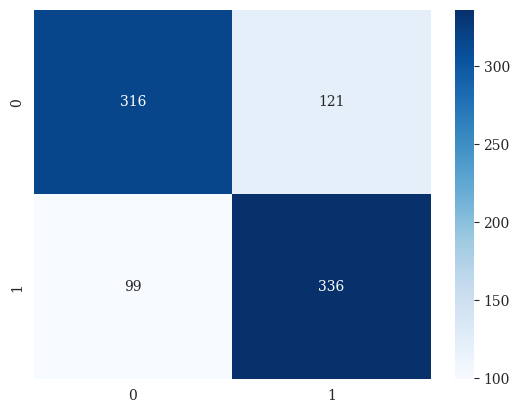

In [48]:
# visualizzo la matrice di confusione

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

In [52]:
# re-inizializzo i TrainingArgument con 2 epoche

training_args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy = "epoch",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

In [53]:
# inizializzo il Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [54]:
# addestro e salvo il modello

trainer.train()
trainer.save_model("/content/drive/My Drive/FINETUNED_MODEL_irony")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.193800,1.434020,0.748515
2,0.045700,1.590963,0.761052


In [55]:
# calcolo del predictions del modello

output_predictions = trainer.predict(test)

In [56]:
# testo il modello

y_test = test["label"].tolist()
y_pred = np.argmax(output_predictions.predictions, axis=1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.64      0.72       437
           1       0.70      0.84      0.77       435

    accuracy                           0.74       872
   macro avg       0.75      0.74      0.74       872
weighted avg       0.75      0.74      0.74       872



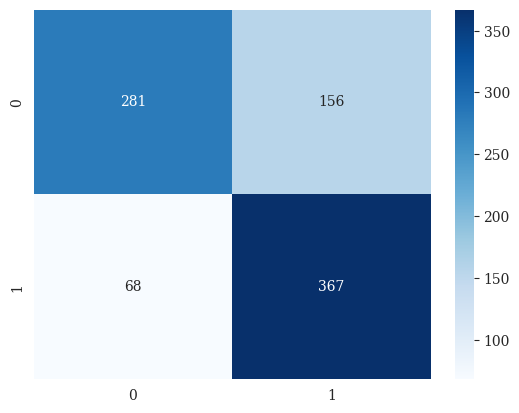

In [57]:
# visualizzo la matrice di confusione

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

## Classificazione multi-classe di irony_sarcasm

In [58]:
# formatto i dati per passarli a transformer.Dataset

train = df_train[['twitter_id', 'text', 'irony_sarcasm']]
train = train.rename(columns={'irony_sarcasm': 'label'})
test = df_test[['twitter_id', 'text', 'irony_sarcasm']]
test = test.rename(columns={'irony_sarcasm': 'label'})

In [59]:
print(train.shape, test.shape)

(3977, 3) (872, 3)


In [60]:
train.head()

,twitter_id,text,label
872,790984955396489217,in Europa #Renzi batte i pugni per migranti p...,0
873,511508648909344768,-Fatti i compiti per le vacanze? -No. -Cominci...,1
874,146306463130849280,: abbiamo voluto la bicicletta (il Governo Mon...,1
875,837044424626450432,: Milano: il condominio dove comandano i profu...,0
876,522755524065247232,... e alla fine nuovo (consueto) blocco del co...,2


In [61]:
test.head()

,twitter_id,text,label
0,595524450503815168,-Prendere i libri in copisteria-Fare la spesa-...,1
1,578468106504433665,...comunque con una crociera Costa se non ti a...,1
2,577791521174466560,"“@TweetComici: Ogni ragazza: \""non sono una ra...",2
3,507464919303069697,“La buona scuola”? Fa gli errori di grammatica...,0
4,839896135619727362,“Vi hanno sfrattato? Andate al campo rom in un...,0


In [62]:
# passo i pandas.DataFrame a transformer.Datasets e rimuovo la colonna corrispondente all'indice

train = datasets.Dataset.from_pandas(train)
test = datasets.Dataset.from_pandas(test)
train = train.remove_columns(["__index_level_0__"])
test = test.remove_columns(["__index_level_0__"])

In [63]:
print(train)

Dataset({
    features: ['twitter_id', 'text', 'label'],
    num_rows: 3977
})


In [64]:
print(test)

Dataset({
    features: ['twitter_id', 'text', 'label'],
    num_rows: 872
})


In [65]:
# Separo train e validation

train_dev = train.train_test_split(test_size=0.1)

train = train_dev["train"]
val = train_dev["test"]

In [66]:
print(train)

Dataset({
    features: ['twitter_id', 'text', 'label'],
    num_rows: 3579
})


In [67]:
print(val)

Dataset({
    features: ['twitter_id', 'text', 'label'],
    num_rows: 398
})


In [68]:
# carico il modello ed il tokenizzatore

num_labels = len(np.unique(train['label']))
model_name = 'dbmdz/bert-base-italian-cased'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

In [69]:
# tokenizzo i dati

def tokenize(batch):
    tokens = tokenizer(batch['text'], padding=True, truncation=True, max_length=188)
    tokens['label'] = batch['label']

    return tokens

train = train.map(tokenize, batched=True)
val = val.map(tokenize, batched=True)
test = test.map(tokenize, batched=True)

train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/3579 [00:00<?, ? examples/s]

Map:   0%|          | 0/398 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [70]:
train

Dataset({
    features: ['twitter_id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3579
})

In [71]:
val

Dataset({
    features: ['twitter_id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 398
})

In [72]:
test

Dataset({
    features: ['twitter_id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 872
})

In [73]:
# inizializzo i TrainingArgumets

training_args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy = "epoch",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

In [74]:
# definisco una funzione per la valutazione del modello (f1-macro)

def compute_metrics(eval_pred):
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)

  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [75]:
# inizializzo il Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [76]:
# addestro e salvo il modello

trainer.train()
trainer.save_model("/content/drive/My Drive/FINETUNED_MODEL_sarcasm")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.907500,0.783274,0.563084
2,0.702900,0.771049,0.588959
3,0.474100,0.933346,0.595845
4,0.310100,1.077309,0.602892
5,0.198900,1.220821,0.597486


<ipython-input-78-fe6f7d53686a>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "TR"}, ignore_index=True)
<ipython-input-78-fe6f7d53686a>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "VL"}, ignore_index=True)
<ipython-input-78-fe6f7d53686a>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "TR"}, ignore_index=True)
<ipython-input-78-fe6f7d53686a>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(

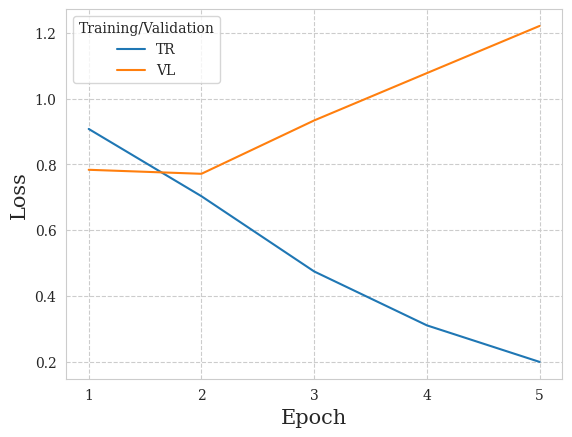

In [78]:
# visualizzo la loss su TR/VL

log_history = trainer.state.log_history
data = pd.DataFrame(columns=["Epoch", "Loss", "Training/Validation"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    data = data.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "TR"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    data = data.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "VL"}, ignore_index=True)

# Lineplot della loss
sns.lineplot(data=data, x="Epoch", y="Loss", hue="Training/Validation")
plt.xticks(range(1, 6))
plt.show()

In [79]:
# calcolo le predictions del modello

output_predictions = trainer.predict(test)

In [80]:
# testo il modello

y_test = test["label"].tolist()
y_pred = np.argmax(output_predictions.predictions, axis=1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       437
           1       0.42      0.55      0.47       219
           2       0.58      0.32      0.42       216

    accuracy                           0.60       872
   macro avg       0.57      0.54      0.54       872
weighted avg       0.61      0.60      0.59       872



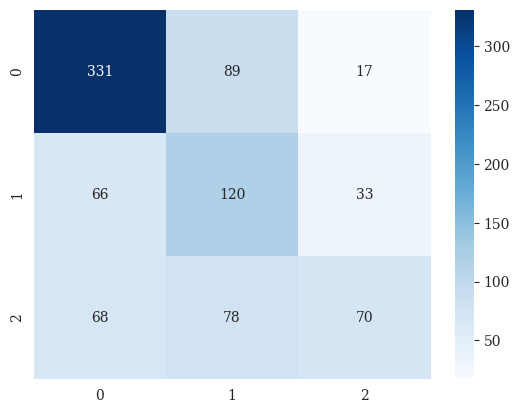

In [81]:
# visualizzo la matrice di confusione

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

In [83]:
# re-inizializzo i TrainingArguments con 2 epoche

training_args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy = "epoch",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

In [84]:
# inizializzo il Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [85]:
# ri-addestro e salvo il modello

trainer.train()
trainer.save_model("/content/drive/My Drive/FINETUNED_MODEL_sarcasm")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.383700,1.083083,0.590954
2,0.152300,1.433957,0.601891


In [86]:
# calcolo le predictions del modello

output_predictions = trainer.predict(test)

In [87]:
# testo il modello

y_test = test["label"].tolist()
y_pred = np.argmax(output_predictions.predictions, axis=1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.65      0.70       437
           1       0.39      0.45      0.42       219
           2       0.44      0.51      0.47       216

    accuracy                           0.56       872
   macro avg       0.53      0.54      0.53       872
weighted avg       0.59      0.56      0.57       872



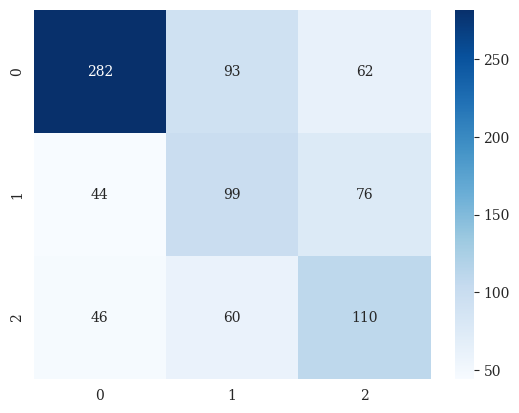

In [88]:
# visualizzo la matrice di confusione

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()